
## Power Limit Data Processing Script

Copyright 2019 - Charles Vorbach

Released under [GNU General Public License v3.0](https://www.gnu.org/licenses/gpl-3.0.en.html)


In [1]:

# Imports

import numpy as np
import matplotlib.pyplot as plt

import math
    
# Enables interactive plots
# %matplotlib notebook
    

In [19]:

# Load data from vehicle log
data = np.load('20191020121342.npz')

# Print fields of structured array
# for k in data:
#     print(k)

In [20]:

# Sorts series with out-of-order timestamps
def clean_series(times, vals):
    
    # Make everything a float
    times = np.float64(times)
    vals  = np.float64(vals) 
    
    sorted_perm = times.argsort() # Time in increasing order
    
    times = times[sorted_perm]    # Permute to match
    times = times - times[0]      # Start at time zero
    
    vals = vals[sorted_perm]      # Permute to match times
    
    return times, vals            # Note, the passed array's haven't been changed


/home/charlie/.pyenv/versions/3.8.0/envs/james-watt/lib/python3.8/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/charlie/.pyenv/versions/3.8.0/envs/james-watt/lib/python3.8/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


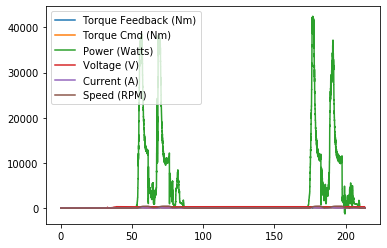

In [21]:

# Name interesting series

# FEEDBACK TORQUE
feedback_times =       data['control__RMSTorqueTimerInfo']['time']
feedback_vals  = 0.1 * data['control__RMSTorqueTimerInfo']['torque_feedback']  # converts dNm -> Nm
feedback_times, feedback_vals = clean_series(feedback_times, feedback_vals)

plt.plot(feedback_times, feedback_vals, label='Torque Feedback (Nm)')

# COMMANDED TORQUE
cmd_times =       data['control__RMSCmd']['time']
cmd_vals  = 0.1 * data['control__RMSCmd']['torque']                            # converts dNm -> Nm
cmd_times, cmd_vals = clean_series(cmd_times, cmd_vals)

plt.plot(cmd_times, cmd_vals, label='Torque Cmd (Nm)')

# POWER 
pwr_times = data['critical__CurrentSensor_Power']['time']
pwr_vals  = data['critical__CurrentSensor_Power']['result']                    # watts
pwr_times, pwr_vals = clean_series(pwr_times, pwr_vals)

plt.plot(pwr_times, pwr_vals, label='Power (Watts)')

# VOLTAGE
volt_times =         data['critical__CurrentSensor_Voltage1']['time']
volt_vals  = 0.001 * data['critical__CurrentSensor_Voltage1']['result']       # converts mV -> V 
volt_times, volt_vals = clean_series(volt_times, volt_vals)

plt.plot(volt_times, volt_vals, label='Voltage (V)')

# CURRENT
curr_times =         data['critical__CurrentSensor_Current']['time']          
curr_vals  = 0.001 * data['critical__CurrentSensor_Current']['result']        # converts mA -> A
curr_times, curr_vals = clean_series(curr_times, curr_vals)

plt.plot(curr_times, curr_vals, label='Current (A)')

# RESOLVER
resolver_times = data['control__RMSMotorPositionInfo']['time']
resolver_vals =  data['control__RMSMotorPositionInfo']['motor_speed'] * math.pi / 30  # converts RPM -> rad/s
resolver_times, resolver_vals = clean_series(resolver_times, resolver_vals)

plt.plot(resolver_times, resolver_vals, label='Speed (RPM)')

plt.legend()

In [22]:

# Interpolate to get a single time vector

time = pwr_times

interp_feedback = np.interp(time, feedback_times, feedback_vals)
interp_cmd      = np.interp(time, cmd_times, cmd_vals)
interp_pwr      = np.interp(time, pwr_times, pwr_vals)
interp_volt     = np.interp(time, volt_times, volt_vals)
interp_curr     = np.interp(time, curr_times, curr_vals)
interp_resolver = np.interp(time, resolver_times, resolver_vals)

# Plot if you like

# plt.plot(time, interp_feedback, '.', label='Feedback')
# plt.plot(time, interp_cmd,      '.', label='Command')
# plt.plot(time, interp_pwr,      '.', label='Power')
# plt.plot(time, interp_volt,     '.', label='Voltage')
# plt.plot(time, interp_curr,     '.', label='Current')
# plt.plot(time, interp_resolver, '.', label='Resolver')
# plt.legend()


In [23]:

# The current sensor does 0th order interpolation between 33 hertz updates
# The voltage and current have been linearly interpolated and so are less laggy

computed_pwr = interp_volt * interp_curr
power = computed_pwr                        # Use this power

# Plot if you like

# plt.plot(t, computed_pwr, '.', label='Voltage*Current (After Interpolation)')
# plt.plot(t, power, '.',   label='Power Message')
# plt.legend()


In [24]:

# Raw mechanical power prediction

cmd_prediction      = (interp_resolver * interp_cmd)          # Compute from driver's torque command
feedback_prediction = (interp_resolver * interp_feedback)     # Compute from rinehart feedback torque measure

# Use this prediction
pwr_prediction = feedback_prediction

# Plot if you like

# plt.plot(time, feedback_prediction, label='Feedback Power Prediction (Watts)')
# plt.plot(time, cmd_prediction, label='CMD Power Prediction (Watts)')
# plt.plot(time, power, label='Electrical Power (Watts)')
# plt.legend()

In [25]:

# Find power's lag w.r.t. the predicted power
# This is mostly an issue if you're not using computed power

# Number of indexes to check for lag
k = 100 

# Get correlation
model_correl = np.correlate(power, pwr_prediction[:-k], mode='valid')
model_correl = model_correl / np.correlate(power, power)

# Print info
print('Signal Length:', len(power))
max_idx = np.argmax(model_correl)
print('Correlation Max Loc:', max_idx)
lag = max_idx
print('Lag Steps:', lag)

# Stochastically estimate lag time
from random import randrange

lag_times = [time[lag + loc] - time[loc] for loc in [randrange(len(time) - lag) for i in range(100)]]

print('Lag Time:', np.average(lag_times), 's')
print('Normalized Max Correlation:', max(model_correl))

# Plot if you like

# plt.plot(model_correl)
# plt.title("Correlation Coefficient vs Index Shift")


Signal Length: 202198
Correlation Max Loc: 6
Lag Steps: 6
Lag Time: 0.006350002288818359 s
Normalized Max Correlation: 0.8670633268930569


In [26]:

# Unshift power to remove lag

shift_pwr = np.pad(power, (lag,))

k=2*lag-1
shift_pwr = shift_pwr[k:-1]

power = shift_pwr # Update power

# Plot if you like

# plt.plot(time, power, label='Shifted Power')
# plt.plot(time, pwr_prediction, label='Predicted Power')
# plt.legend()

Text(0.5, 1.0, 'Raw Mechanical Power Model')

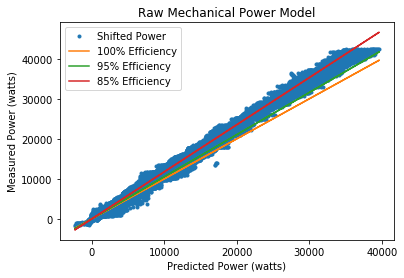

In [27]:

# Plot raw mechanical prediction against measured power

plt.plot(pwr_prediction, power, '.', label='Shifted Power')
plt.plot(pwr_prediction, pwr_prediction * 1/1, label='100% Efficiency')
plt.plot(pwr_prediction, pwr_prediction * 1/0.95, label='95% Efficiency')
# plt.plot(pwr_prediction, pwr_prediction * 1/0.9, label='90% Efficiency')
plt.plot(pwr_prediction, pwr_prediction * 1/0.85, label='85% Efficiency')
# plt.plot(pwr_prediction, pwr_prediction * 1/0.6, label='70% Efficiency')

plt.legend()
plt.xlabel("Predicted Power (watts)")
plt.ylabel("Measured Power (watts)")
plt.title('Raw Mechanical Power Model')


Text(0, 0.5, 'Feedback Torque (Nm))')

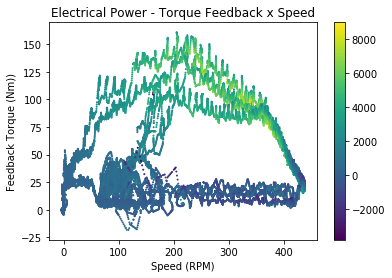

In [28]:

# Plot raw residuals on torque speed curve

res = power - pwr_prediction

fig = plt.figure()
ax = fig.add_subplot(111)
pos = ax.scatter(interp_resolver, interp_feedback, c=res, s=1)

fig.colorbar(pos, ax=ax)

plt.title('Electrical Power - Torque Feedback x Speed')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')


# You should be able to see the large residuals from field weakening above


Text(0, 0.5, 'Efficiency')

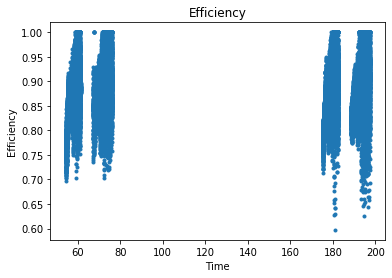

In [29]:

# Compute Efficiency

# Unfortunatly, we have to clip efficiencies to a valid range.
# The efficiency are sometimes invalid because the data is 
# out of sync, or feedback torque isn't equal to actual torque
MAX_EFF = 1.0
MIN_EFF = 0.45
MIN_POWER  = 10000

efficiency = np.clip(np.abs(pwr_prediction) / (power**2 + 1)**(0.5), a_min=MIN_EFF, a_max=MAX_EFF)

# At low powers, this measure of efficiency is inaccurate 
# b/c resitive losses in the motor windings and because
# sometimes the rinehart's feedback torque measure is wildly wrong
efficiency[power < MIN_POWER]                  = np.nan

# Plot if you like

plt.plot(time, efficiency, ".")
plt.title("Efficiency")
plt.xlabel("Time")
plt.ylabel("Efficiency")

In [30]:

# Save processed data to compare against other runs

run_3 = np.column_stack((interp_resolver, interp_feedback, efficiency, power, pwr_prediction, time))


In [46]:

# Write combined data to file

combined_data = np.vstack((run_1,run_2,run_3)) # run_1, run_2, ...
np.save("combined-runs", combined_data)


In [4]:

# Load combined data from file

combined_data = np.load("example-combined-data.npy")


In [5]:

# Name and clean combined data (runs probably don't have times in order)
# This produces a "merged" run

cmb_resolver = combined_data[:, 0]
cmb_feedback = combined_data[:, 1]
cmb_eff      = combined_data[:, 2]
cmb_power    = combined_data[:, 3]
cmb_predict  = combined_data[:, 4]
cmb_time     = combined_data[:, 5]

raw_time     = np.copy(cmb_time) 

cmb_time, cmb_resolver = clean_series(cmb_time,          cmb_resolver)
_, cmb_feedback        = clean_series(np.copy(raw_time), cmb_feedback)
_, cmb_eff             = clean_series(np.copy(raw_time), cmb_eff)
_, cmb_power           = clean_series(np.copy(raw_time), cmb_power)
_, cmb_predict         = clean_series(np.copy(raw_time), cmb_predict)



Text(0, 0.5, 'Feedback Torque (Nm))')

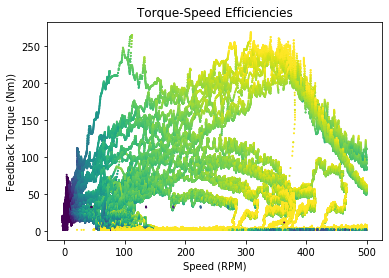

In [6]:

# Trim off data contaminated by overspeed fault

OVERSPEED = 500  # Going faster than this triggers a fault and produces garbage data

good_idx = cmb_resolver < OVERSPEED

time            = cmb_time[good_idx]
feedback        = cmb_feedback[good_idx]
power           = cmb_power[good_idx]
predict         = cmb_predict[good_idx]
resolver        = cmb_resolver[good_idx]
efficiency      = cmb_eff[good_idx]

plt.scatter(resolver, feedback, c=efficiency, s=1)

plt.title('Torque-Speed Efficiencies')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')


In [7]:

# COMPUTE EFFICIENCY MAP BY AVERAGING AROUND GRIDPOINTS

# Change Me :)
BUCKETS = 40
MIN_BUCKET_SIZE = 50
MAX_TORQUE = 270
MAX_SPEED = 500

TORQUE_STEP = MAX_TORQUE / (BUCKETS)
SPEED_STEP = MAX_SPEED / (BUCKETS)

speeds  = [ SPEED_STEP * i for i in range(1, BUCKETS + 1)]
torques = [TORQUE_STEP * i for i in range(1, BUCKETS + 1)] 

# Alias with shorter names
trq     = feedback
spd     = resolver
pwr     = power
predict = predict

vv, tt = np.meshgrid(speeds, torques)

eff_map = np.zeros((len(speeds), len(torques)))
eff_map[:, :] = np.nan

for i,t in enumerate(torques):
    for j,v in enumerate(speeds):
                
        trq_bnd = (t - TORQUE_STEP/2, t + TORQUE_STEP/2)
        spd_bnd = (v - SPEED_STEP/2,  v + SPEED_STEP/2)
        
        # Get efficiencies in bounds
        bucket_idx = np.logical_and(
                np.logical_and(trq >= trq_bnd[0], trq < trq_bnd[1]),
                np.logical_and(spd >= spd_bnd[0], spd < spd_bnd[1])
            )
        
        # Skip invalid efficiencies
        bucket_idx = np.logical_and(
                ~np.isnan(efficiency),
                bucket_idx
            )

        # Skip empty buckets
        if np.sum(bucket_idx) < MIN_BUCKET_SIZE:
            continue
                            
        eff_map[i, j] = np.average(efficiency[bucket_idx])


Text(0, 0.5, 'Feedback Torque (Nm))')

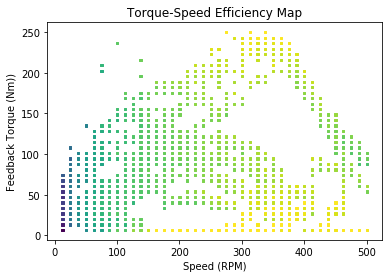

In [8]:

# Plot map

plt.scatter(vv, tt, c=eff_map, s=5, marker='s')

plt.title('Torque-Speed Efficiency Map')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')

Text(0, 0.5, 'Feedback Torque (Nm))')

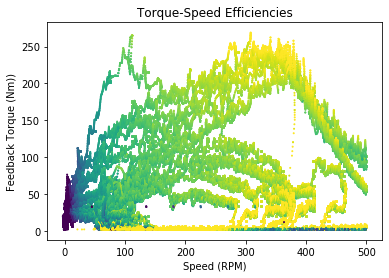

In [9]:

# Plot torque-speed efficiencies over map

plt.scatter(vv, tt, c=eff_map, s=5, marker='s')
plt.scatter(resolver, feedback, c=efficiency, s=1)

plt.title('Torque-Speed Efficiencies')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')

In [10]:

# Interpolate inner map points

from scipy import interpolate
import scipy.signal

valid_mask = ~np.isnan(eff_map)
coords = np.array(np.nonzero(valid_mask)).T

values = eff_map[valid_mask]

it = interpolate.LinearNDInterpolator(coords, values, fill_value=np.nan)

filled = it(list(np.ndindex(eff_map.shape))).reshape(eff_map.shape)

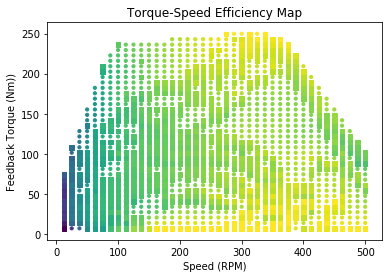

In [11]:

# SHOWS INTERPOLATION EFFECTS

measured_eff = eff_map

plt.scatter(vv, tt, c=measured_eff, s=20, marker='s')
plt.scatter(vv, tt, c=filled, s=10)
plt.title('Torque-Speed Efficiency Map')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')


# UPDATE EFFICIENCY MAP
eff_map = filled

In [12]:

# Extrapolate from boundaries

from scipy.interpolate import griddata

v  = np.reshape(vv, (-1,))
t  = np.reshape(tt, (-1,))
ef = np.reshape(eff_map, (-1,)) 

points = np.array(list(zip(v,t)))

nan_mask = np.isnan(ef)

extrapolated = griddata(points[~nan_mask], ef[~nan_mask], (vv, tt), method='nearest')

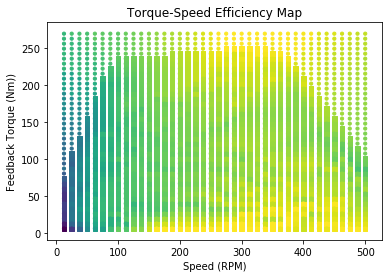

In [13]:

# SHOWS EXTRAPOLATION EFFECTS

plt.scatter(vv, tt, c=eff_map, s=20, marker='s')
plt.scatter(vv, tt, c=extrapolated, s=10)

plt.title('Torque-Speed Efficiency Map')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')

# UPDATE EFFICIENCY MAP
eff_map = extrapolated

Text(0, 0.5, 'Feedback Torque (Nm))')

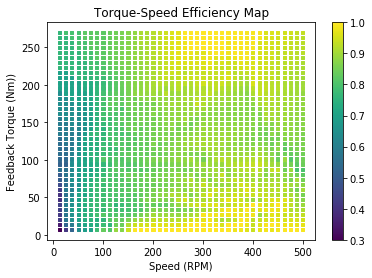

In [14]:

# FINAL EFFICIENCY MAP

fig = plt.figure()

ax = fig.add_subplot(111)

pos = ax.scatter(vv, tt, c=eff_map, s=10, marker='s')

fig.colorbar(pos, ax=ax)

plt.title('Torque-Speed Efficiency Map')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')

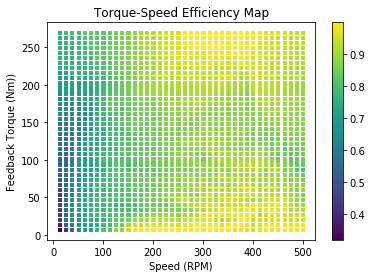

In [15]:

# Optionally blur map a bit

from scipy import ndimage
blurred_map = ndimage.convolve(eff_map, np.array([   
                                                [0.0375, 0.0375, 0.0375],
                                                [0.0375, 0.7, 0.0375],
                                                [0.0375, 0.0375, 0.0375]
                                            ]))

fig = plt.figure()

ax = fig.add_subplot(111)

pos = ax.scatter(vv, tt, c=blurred_map, s=10, marker='s')

fig.colorbar(pos, ax=ax)

plt.title('Torque-Speed Efficiency Map')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')

# UPDATE EFFICIENCY MAP
eff_map = blurred_map

In [18]:

# Produce c++ map for embedded controller

serialized_map = str(np.around(eff_map, 6).tolist())

translation = str.maketrans("[]", "{}")

c_literal = serialized_map.translate(translation) \
            .replace("},", "},\n") \
            .replace("{{", "{\n{") \
            .replace("}}", "}\n}")

print("")
print("// GENERATED FROM PYTHON POWER LIMITING EFFICIENCY SCRIPT  ")
print("")

print("")
print("// HEADER  ")
print("")

print("static constexpr int TORQUE_POINTS = {};".format(eff_map.shape[0]))
print("static constexpr float TORQUE_STEP = {};     // Nm".format(TORQUE_STEP))
print("static constexpr float STARTING_TORQUE = {};".format(TORQUE_STEP))
print("")
print("static constexpr int SPEED_POINTS  = {};".format(eff_map.shape[1]))
print("static constexpr float SPEED_STEP = {};     // RPM".format(SPEED_STEP))
print("static constexpr float STARTING_SPEED = {};".format(SPEED_STEP))
print("")
print("static constexpr float MAX_EFF = {};".format(MAX_EFF))
print("static constexpr float MIN_EFF = {};".format(MIN_EFF))
print("")
print("static float EFF_GRID[TORQUE_POINTS][SPEED_POINTS];")

print("")
print("// SRC  ")
print("")

print("float MapData::EFF_GRID[TORQUE_POINTS][SPEED_POINTS] = ")
print(c_literal + ";")



// GENERATED FROM PYTHON POWER LIMITING EFFICIENCY SCRIPT  


// HEADER  

static constexpr int TORQUE_POINTS = 40;
static constexpr float TORQUE_STEP = 6.75;     // Nm
static constexpr float STARTING_TORQUE = 6.75;

static constexpr int SPEED_POINTS  = 40;
static constexpr float SPEED_STEP = 12.5;     // RPM;
static constexpr float STARTING_SPEED = 12.5;

static constexpr float MAX_EFF = 1.0;     // RPM;
static constexpr float MIN_EFF = 0.45;

static float EFF_GRID[TORQUE_POINTS][SPEED_POINTS];

static constexpr int SPEED_POINTS  = 40;

// SRC  

float MapData::EFF_GRID[TORQUE_POINTS][SPEED_POINTS] = 
{
{0.320943, 0.421039, 0.532413, 0.634436, 0.686466, 0.70536, 0.775928, 0.820252, 0.816604, 0.87442, 0.876359, 0.94023, 0.989077, 0.994373, 0.995204, 0.995689, 0.996197, 0.995992, 0.995863, 0.996386, 0.997736, 0.998953, 0.997831, 0.999289, 0.997709, 0.995572, 0.997089, 0.995352, 0.984991, 0.984826, 0.965311, 0.948822, 0.971822, 0.985401, 0.979157, 0.98491, 0.994577, 0.99674, 0.993212, 0

In [ ]:
# Alternatively load a different efficiency map


In [60]:

# USE EFFICIENCY MAP TO COMPUTE NEW POWER PREDICTIONS

from scipy.interpolate import interp2d
f = interp2d(vv, tt, eff_map)

eff_estimate = np.zeros((len(power),))

for i, (v, t) in enumerate(zip(spd, trq)):
    eff_estimate[i] = f(v, t)

eff_estimate = np.clip(eff_estimate, a_min=MIN_EFF, a_max=MAX_EFF)
eff_predict = predict / eff_estimate    


Text(0, 0.5, 'Power (Watts)')

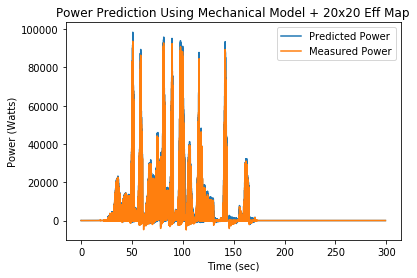

In [61]:

# Plot prediction and measured power

plt.plot(time, eff_predict, label='Predicted Power')
plt.plot(time, power, label='Measured Power')
plt.legend()

plt.title('Power Prediction Using Mechanical Model + 20x20 Eff Map')
plt.xlabel('Time (sec)')
plt.ylabel('Power (Watts)')


99th Percentile Residual:  2632.326472053759


Text(0, 0.5, 'Feedback Torque (Nm))')

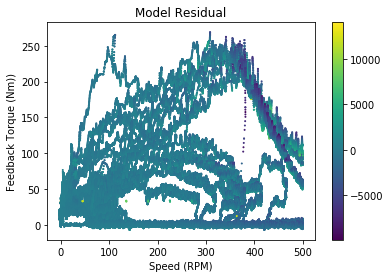

In [62]:

# Plot model residual

res = power - eff_predict

fig = plt.figure()
ax = fig.add_subplot(111)

pos = ax.scatter(resolver, feedback, c=res, s=1)

print("99th Percentile Residual: ", np.percentile(np.abs(res), 99))

fig.colorbar(pos, ax=ax)

plt.title('Model Residual')
plt.xlabel('Speed (RPM)')
plt.ylabel('Feedback Torque (Nm))')




Text(0.5, 1.0, 'Power Prediction Using Mechanical Model + 20x20 Eff Map')

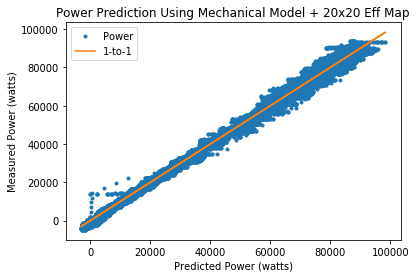

In [63]:

# Plot power at prediction

plt.plot(eff_predict, power, '.', label='Power')
plt.plot(eff_predict, eff_predict, label='1-to-1')

plt.legend()
plt.xlabel("Predicted Power (watts)")
plt.ylabel("Measured Power (watts)")
plt.title('Power Prediction Using Mechanical Model + 20x20 Eff Map')


Text(0, 0.5, 'Power (Watts)')

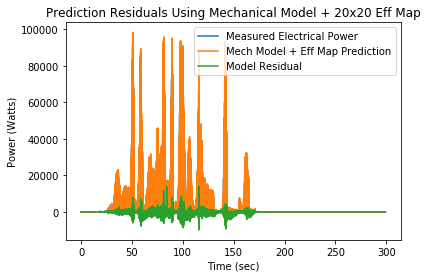

In [64]:
residual = power - eff_predict

plt.plot(time, power, label='Measured Electrical Power')
# plt.plot(time, pwr_prediction, label='Predicted Mechanical Power')
plt.plot(time, eff_predict, label='Mech Model + Eff Map Prediction')
plt.plot(time, residual, label='Model Residual')

# plt.plot(time, interp_resolver, label='Speed')
# plt.plot(time, 100*interp_feedback, label='Torque')

plt.legend()

plt.title('Prediction Residuals Using Mechanical Model + 20x20 Eff Map')
plt.xlabel('Time (sec)')
plt.ylabel('Power (Watts)')